In [526]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import pi, c
from scipy import signal

# Radar Model - MIMO

In [527]:
# Single Target

#target_location = np.array([10, 10*np.tan(np.deg2rad(90-30))]) # Target location on 2-dimensional plane [m]
target_location = np.array([0+10, 10*np.tan(np.deg2rad(90-45))])
target_velocity = np.array([5, 5]) # Target velocity in m/s in each dimension [m/s]

In [528]:
# MIMO radar setup

""" TRANSMITTER TXs"""

f_c = 77e9          # start frequency - [Hz]
wavelength = c/f_c  # Lambda wakelength at carrier frequency - [m]

T_c = 25.66e-6      # chirp time/ duration - [s]
bw = 0.77*1e9           # bandwidth eg. from 76. GHz to 77.5 GHz - [Hz]
S = bw/T_c          # chirp rate - [Hz/s]
prf = 1/T_c         # pulse repetition frequency - [Hz]

M = 64              # number of chirps

TX_locations = np.array(([-12*(wavelength/2), 0],
                        [-8*(wavelength/2), 0]))
                        #[-4*(wavelength/2), 0],
                        #[[0*(wavelength/2), 0]]) # remeber to set 1 TX like this : np.array([[0, 0]]) ensure shape (1,2)
                        #[-3*wavelength, 0]))    # Transmitter location on 2-dimensional plane [m]

                                    # TI har 3 transmitter
                                    # Unilateral antenna array: 1 lambda spacing between antennas


""" RECEIVER RXs"""

fs = 0.5e9           # sampling frequency - [Hz]
Ns = 64           # number of samples (ADC) - [samples]

RX_locations = np.array((#[(-3/2)*(wavelength/2), 0],
                        [(-1/2)*(wavelength/2), 0],
                        [(1/2)*(wavelength/2), 0]))#,
                        #[(3/2)*(wavelength/2), 0]))
                        #[7*(wavelength/2), 0],
                        #[8*(wavelength/2), 0]))  # Receiver location on 2-dimensional plane [m]
    
                                    # TI har 4 receiver
                                    # Unilateral antenna array: 1/2 lambda spacing between antennas

""" Path loss """

gain = 1            # gain of the antenna - [dB]
transmit_power = 1  # transmit power - [W]
rcs = 1             # radar cross section - [m^2]

""" SNR """

SNR = 1            # signal to noise ratio - [dB]



In [529]:
print(f"wavelength: {wavelength} m \n chirp_rate: {S} Hz/s \n prf: {prf} Hz \n TX_locations: {TX_locations} m \n RX_locations: {RX_locations} m")

print(f"range resolution: {c/(2*bw)}")

wavelength: 0.0038934085454545454 m 
 chirp_rate: 30007794232268.12 Hz/s 
 prf: 38971.16134060795 Hz 
 TX_locations: [[-0.02336045  0.        ]
 [-0.01557363  0.        ]] m 
 RX_locations: [[-0.00097335  0.        ]
 [ 0.00097335  0.        ]] m
range resolution: 0.19467042727272726


In [530]:
"""Compute all radial distances from the target to the TXs and RXs"""
r_TX = np.linalg.norm(TX_locations - target_location, axis=1)
r_RX = np.linalg.norm(RX_locations - target_location, axis=1)

r_TX, r_RX

(array([14.15866359, 14.15315213]), array([14.1428239 , 14.14144738]))

In [531]:
for tx in range(len(np.array(([0,3], [0,2], [0,1])))):
    print(tx)

0
1
2


In [532]:
"""Compute all radial velocities from the target to the TXs and RXs"""

def compute_radial_velocity(x_target, y_target, x_target_velocity, y_target_velocity, x_base, y_base):
    dx = x_target - x_base
    dy = y_target - y_base
    distance = np.sqrt(dx**2 + dy**2)
    radial_velocity = (dx * x_target_velocity + dy * y_target_velocity) / distance
    return radial_velocity

v_TX = compute_radial_velocity(target_location[0], target_location[1], target_velocity[0], target_velocity[1], TX_locations[0][0], TX_locations[0][1])
v_RX = compute_radial_velocity(target_location[0], target_location[1], target_velocity[0], target_velocity[1], RX_locations[:,0], RX_locations[:,1])

print(v_TX, v_RX)

np.dot(np.array([target_velocity[0], target_velocity[1]]), np.array([target_location[0], target_location[1]])-np.array([TX_locations[0][0], TX_locations[0][1]])) / np.linalg.norm(np.array([target_location[0], target_location[1]])-np.array([TX_locations[0][0], TX_locations[0][1]]))


7.071062999671903 [7.0710678 7.0710678]


np.float64(7.071062999671903)

In [533]:
np.array([[0,0]]).flatten().shape

(2,)

In [534]:
""" Compute intermediate frequency (IF) signal frequency for TX-RX pair """

def compute_IF(r_TX, r_RX):
    IF_signal = (S*(r_TX+r_RX))/ c
    return IF_signal

""" Compute the phase shift of the IF signal """

def compute_phase_shift():
    phase_shift = 2*pi*f_c*(2*(v_TX*T_c)/c)
    return phase_shift

""" Compute the phase difference between the TX and RX antenna pairs"""

def compute_phase_diff(r_tx, r_rx):
    phase_diff = (2*np.pi*(r_rx)) / wavelength # % (2*pi)
    #phase_diff = (2*pi*r_rx*np.sin(np.deg2rad(45)))/wavelength % (2*pi)
    return phase_diff

def compute_phase_diff_antennas(tx_location, rx_location):
    # Virtual antenna placement
    vrx_location = tx_location + rx_location
    phase_diff_antennas = np.arctan((target_location[1]-vrx_location[1])/(target_location[0]-vrx_location[0]))
    print(phase_diff_antennas)
    return phase_diff_antennas


In [535]:
compute_phase_diff(r_TX, r_RX)

array([22823.69864877, 22821.4772073 ])

In [536]:
compute_phase_diff_antennas(TX_locations[0], RX_locations[1]) - compute_phase_diff_antennas(TX_locations[0], RX_locations[0]) 

0.7842800604611495
0.7841829523612274


np.float64(9.710809992213854e-05)

In [537]:
compute_phase_diff_antennas(TX_locations[0], RX_locations[1])

between = np.array([compute_phase_diff_antennas(TX_locations[0], RX_locations[0]), compute_phase_diff_antennas(TX_locations[0], RX_locations[1])])
print(between)
np.degrees(np.arcsin((wavelength*(np.diff(between, axis=0)))/(2*pi*((wavelength/2)))))

0.7842800604611495
0.7841829523612274
0.7842800604611495
[0.78418295 0.78428006]


array([0.00177104])

In [538]:
# Compute the intermediate frequencies for all TX-RX pairs

IF_signals = np.zeros((len(TX_locations), len(RX_locations)))

for t in range(len(TX_locations)):
    for r in range(len(RX_locations)):
        IF_signals[t, r] = compute_IF(r_TX[t], r_RX[r]) # add index to r_TX for multiple transmitters 

# Compute the phase shift of the IF signal

phase_diff = compute_phase_shift() # rad

# Comput the phase difference between the TX and RX antenna pairs

phase_diff_antennas = np.zeros((len(TX_locations), len(RX_locations)))

for t in range(len(TX_locations)):
    for r in range(len(RX_locations)):
        phase_diff_antennas[t, r] = compute_phase_diff(r_TX[t], r_RX[r]) # # add index to r_TX for multiple transmitters 
        print(phase_diff_antennas[t, r])
        

print(IF_signals)
#print(phase_diff)
phase_diff_antennas = phase_diff_antennas - phase_diff_antennas[0,0]
print(phase_diff_antennas)

22823.698648768062
22821.477207301617
22823.698648768062
22821.477207301617
[[2832843.82452509 2832706.04066298]
 [2832292.15342001 2832154.3695579 ]]
[[ 0.         -2.22144147]
 [ 0.         -2.22144147]]


In [539]:
np.diff(phase_diff_antennas, axis=1)

array([[-2.22144147],
       [-2.22144147]])

In [540]:
np.degrees(np.arcsin((wavelength*(np.diff(phase_diff_antennas, axis=1)))/(2*np.pi*((wavelength/2)))), dtype=np.float64)

array([[-44.99999993],
       [-44.99999993]])

In [541]:
# SNR:

SNR = 10 # dB
SNR_distance = 10 # m

snr_linear = 10 ** (SNR / 10)

recieved_power = ((transmit_power * gain * (wavelength ** 2) * rcs) / (((4 * pi) ** 3) * ((SNR_distance) ** 4)))
noise_power = recieved_power / snr_linear

snr_linear, recieved_power, noise_power

(10.0, 7.638891885764579e-13, 7.638891885764579e-14)

In [542]:
""" Create all frames for all TX-RX pair IF signals """

times = np.linspace(0, Ns/fs, Ns)

# Window function

window = signal.windows.blackman(Ns)

IF_signals_data = {}

for t in range(len(TX_locations)):
    for r in range(len(RX_locations)):
        
        frame = np.zeros((M, Ns), dtype=complex)
        for m in range(M):
            frame[m, :] = (
            (np.sqrt((transmit_power * gain * (wavelength ** 2) * rcs) / (((4 * pi) ** 3) * ((r_RX[r]) ** 4))))
            * np.exp(1j * (2 * pi * IF_signals[t, r] * times + m * phase_diff + phase_diff_antennas[t, r] - (2*pi*S*(2*(v_RX[0]*T_c)/c))*times +
                      pi*S*(2*(v_RX[0]*T_c)/c)**2 + 2*pi*S*((r_TX+r_RX[r])/c)*2*(v_RX[0]*T_c)/c)
            ))
            complex_noise = np.sqrt(noise_power/2) * (np.random.normal(0, 1, frame[m, :].shape) + 1j * np.random.normal(0, 1, frame[m, :].shape))


            # Compute the power of the current signal
            signal_power = np.mean(np.abs(frame[m, :])**2)

            noise_power_computed = np.mean(np.abs(complex_noise)**2)
            
            # Compute the SNR
            snr_measured = signal_power / noise_power_computed
            print(f"SNR: {10 * np.log10(snr_measured):.2f} dB")


            # Add noise and window function
            #frame[m, :] += complex_noise
            #frame[m, :] *= window
        IF_signals_data[(t, r)] = frame # Dette er jo egentlig bare en frame

ValueError: operands could not be broadcast together with shapes (64,) (2,) 

c:\Users\malth\miniconda3\lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\malth\miniconda3\lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


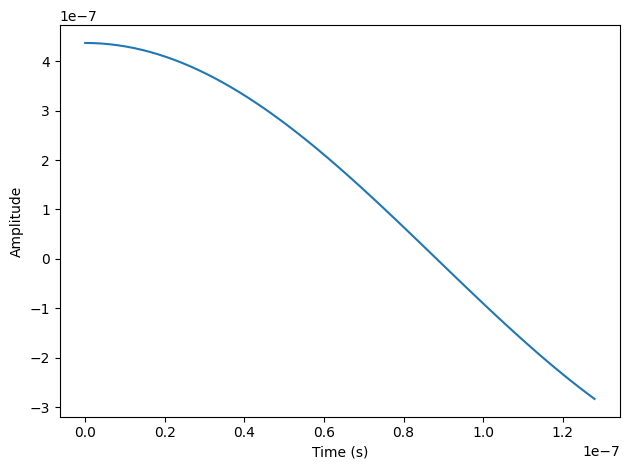

In [ ]:
plt.plot(times, IF_signals_data[0,0][0].T)

plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


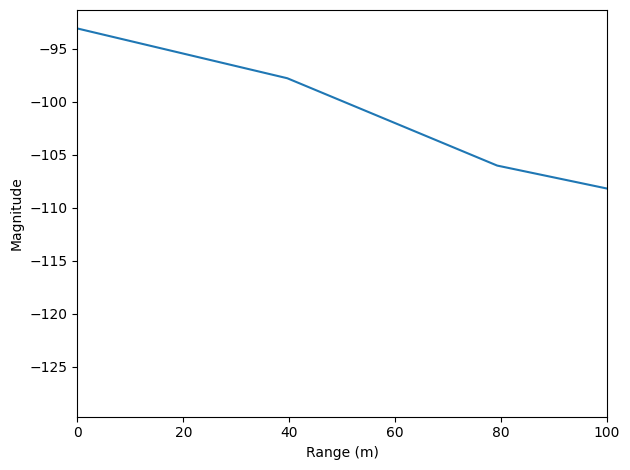

-93.0979766924506
2497.6215819090908


In [ ]:
"""Range FFT """

max_range = (fs*c)/(2*S)
max_vel = wavelength / (4 * T_c) # m/s

ranges = np.linspace(0, max_range, Ns)

X_k = np.fft.fft(IF_signals_data[0,0][0])
X_k = np.abs(X_k)
X_k_db = 20 * np.log10(X_k)

plt.plot(ranges, X_k_db)
plt.xlabel("Range (m)")

plt.ylabel("Magnitude")
plt.xlim([0, 100])

plt.tight_layout()
plt.show()

print(np.max(X_k_db))
print(max_range)


In [ ]:
# Define the window function (e.g., Hamming, Hann, Blackman-Harris)

window = signal.windows.blackman(M)  # Apply a Hamming window

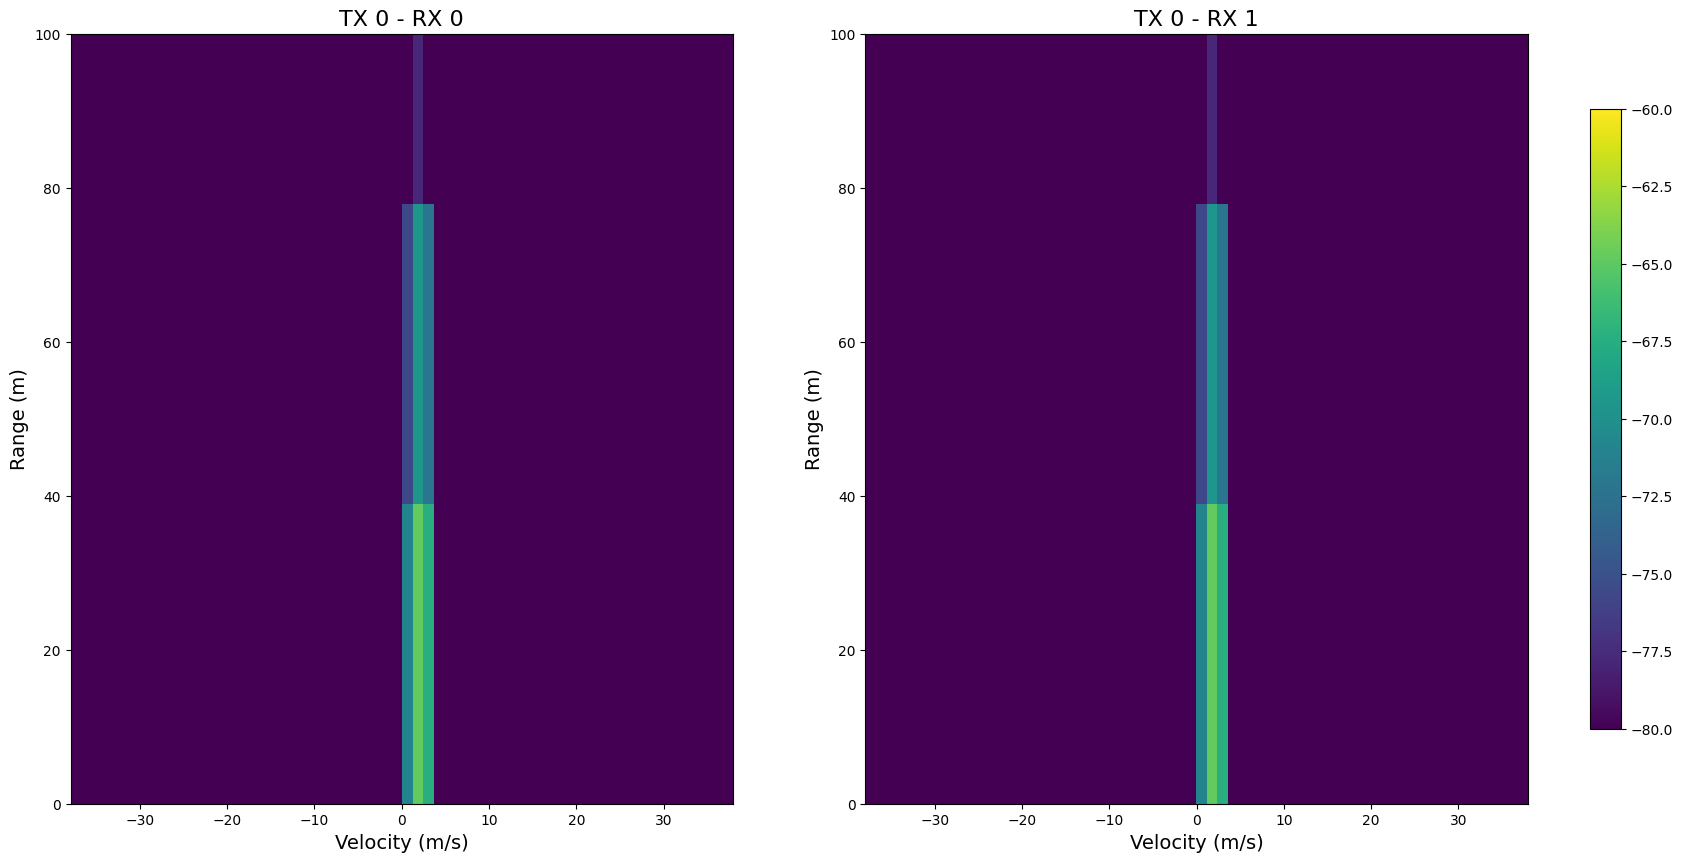

In [ ]:
fig, axs = plt.subplots(1, len(IF_signals_data), figsize=(20, 10))

range_doppler_rxs = {}

for idx, (key, frame) in enumerate(IF_signals_data.items()):
    range_doppler = np.fft.fftshift(np.fft.fft2(frame.T*window), axes=1)
    range_doppler_rxs[idx] = range_doppler

    extent = [-max_vel, max_vel, ranges.min(), ranges.max()]

    range_doppler_plot = axs[idx].imshow(
        20 * np.log10(np.abs(range_doppler)),  # np.abs(...): Takes the magnitude, removing the phase.
        aspect="auto",
        extent=extent,
        origin="lower",
        vmax=-60,
        vmin=-80,
    )
    axs[idx].set_ylim([0, 100])
    axs[idx].set_xlabel("Velocity (m/s)", fontsize=14)
    axs[idx].set_ylabel("Range (m)", fontsize=14)
    axs[idx].set_title(f"TX {key[0]} - RX {key[1]}", fontsize=16)

fig.colorbar(range_doppler_plot, ax=axs, orientation='vertical', fraction=0.02, pad=0.04)
plt.show()


In [ ]:
np.unravel_index(np.argmax(np.abs(range_doppler_rxs[0])), range_doppler_rxs[0].shape)

(np.int64(0), np.int64(33))

In [ ]:
def extract_phasor(fft_2d):
    """
    Extracts the complex phasor from the 2D FFT peak location.

    Parameters:
    fft_2d : np.array
        2D FFT output.

    Returns:
    phasor : complex
        Complex phasor at the peak location.
    """

    # Find peak location in FFT
    peak_index = np.unravel_index(np.argmax(np.abs(fft_2d)), fft_2d.shape)
    print(peak_index)

    # Extract phasor at the peak position
    phasor = fft_2d[peak_index]

    return phasor


phasors = np.array([extract_phasor(range_doppler_rxs[i]) for i in range(len(range_doppler_rxs))])

print(phasors)

#print(range_doppler_rxs[0][0,16])



(np.int64(0), np.int64(33))
(np.int64(0), np.int64(33))
[-9.42730423e-05+0.00056741j  5.08681029e-04-0.00026875j]


In [ ]:
np.angle(phasors)
np.diff(np.angle(phasors))

#np.degrees(np.diff(np.angle(phasors)))
[-3.12963793]

[-3.12963793]

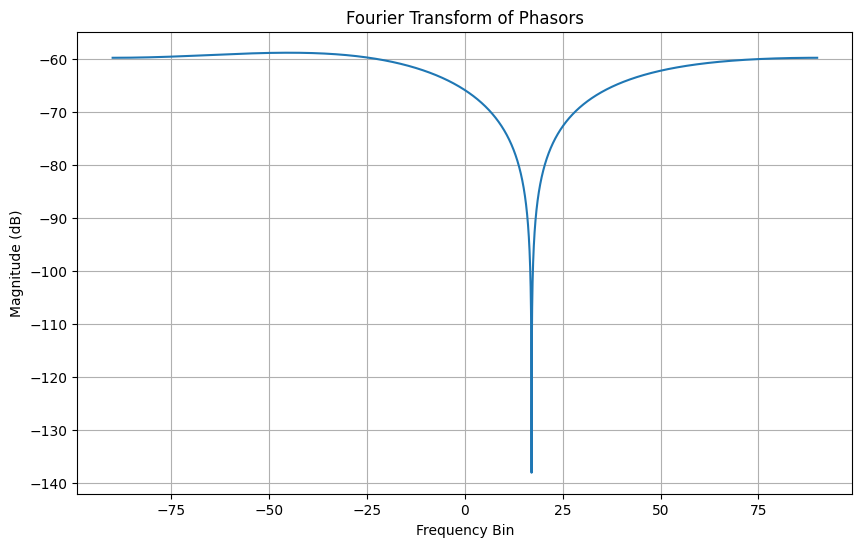

-45.00155729218326
-45.00155729218326


In [ ]:
# Perform Fourier transform on the phasors

# Zero pad fourier transform
phasors_zero_padded = np.pad(phasors, (0, 1000001-len(phasors)), mode='constant')
phasors_fft = np.fft.fftshift(np.fft.fft(phasors_zero_padded))
phasors_fft_magnitude = np.abs(phasors_fft)
phasors_fft_db = 20 * np.log10(np.abs(phasors_fft_magnitude))

anglebins = np.arcsin(np.linspace(-1, 1, 1000001))*180/pi

# Plot the Fourier transform of the phasors
plt.figure(figsize=(10, 6))
plt.plot(anglebins, phasors_fft_db)
plt.xlabel('Frequency Bin')
plt.ylabel('Magnitude (dB)')
plt.title('Fourier Transform of Phasors')
plt.grid(True)
plt.show()

print(anglebins[np.argmax(phasors_fft_db)])
print(anglebins[np.argsort((phasors_fft_db))[-1]])

In [ ]:
closest_to_45 = anglebins[np.abs(anglebins - 45).argmin()]
closest_to_45

np.float64(44.99993670168545)

# Bartlett angle

In [ ]:
def extract_phasor_for_covariance_matrix(fft_2d):
    """
    Extracts the complex phasor from the 2D FFT peak location.

    Parameters:
    fft_2d : np.array
        2D FFT output.

    Returns:
    phasor : complex
        Complex phasor at the peak location.
    """

    # Find peak location in FFT
    peak_index = np.unravel_index(np.argmax(np.abs(fft_2d)), fft_2d.shape)

    # Extract phasor at the peak position and two phasors above and below
    phasors = []
    for i in range(-2, 3):
        idx = (peak_index[0] + i) % fft_2d.shape[0]
        phasors.append(fft_2d[idx, peak_index[1]])
    return phasors


phasors = np.array([extract_phasor_for_covariance_matrix(range_doppler_rxs[i]) for i in range(len(range_doppler_rxs))])

phasors


array([[-5.95202411e-06+8.94156173e-05j, -1.78574772e-05+1.53847948e-04j,
        -9.42730423e-05+5.67409107e-04j,  7.10899061e-05-3.27535430e-04j,
         3.37464612e-05-1.25432648e-04j],
       [ 7.47630664e-05-4.94359556e-05j,  1.33252045e-04-7.89984452e-05j,
         5.08681029e-04-2.68754117e-04j, -3.03711999e-04+1.41859319e-04j,
        -1.20262526e-04+4.91371807e-05j]])

In [ ]:
phasors = np.array([IF_signals_data[0,0][0],IF_signals_data[0,1][0]])
phasors

array([[ 4.36961239e-07+1.88179891e-12j,  4.36675806e-07+1.57912747e-08j,
         4.35820018e-07+3.15600420e-08j,  4.34394991e-07+4.72875879e-08j,
         4.32402587e-07+6.29533699e-08j,  4.29845409e-07+7.85369265e-08j,
         4.26726795e-07+9.40179035e-08j,  4.23050821e-07+1.09376081e-07j,
         4.18822286e-07+1.24591399e-07j,  4.14046715e-07+1.39643984e-07j,
         4.08730344e-07+1.54514175e-07j,  4.02880117e-07+1.69182551e-07j,
         3.96503676e-07+1.83629952e-07j,  3.89609349e-07+1.97837508e-07j,
         3.82206140e-07+2.11786662e-07j,  3.74303721e-07+2.25459195e-07j,
         3.65912411e-07+2.38837249e-07j,  3.57043172e-07+2.51903350e-07j,
         3.47707587e-07+2.64640432e-07j,  3.37917850e-07+2.77031859e-07j,
         3.27686748e-07+2.89061445e-07j,  3.17027644e-07+3.00713479e-07j,
         3.05954461e-07+3.11972742e-07j,  2.94481660e-07+3.22824528e-07j,
         2.82624228e-07+3.33254662e-07j,  2.70397651e-07+3.43249522e-07j,
         2.57817900e-07+3.52796053e-07

In [ ]:
R = phasors @ phasors.conj().T*(1/64) # Covariance matrix

In [ ]:
def doa_bartlett(R, d = 0.5, scan_angles = range(-90, 91)):
    """ bartlett beamforming implementation """
    n_array = np.shape(R)[0]
    array = np.linspace(0, (n_array - 1) * d, n_array)
    scan_angles = np.linspace(-90, 90, 100001)

    array_grid, angle_grid = np.meshgrid(array, np.radians(scan_angles), indexing = "ij")
    steering_vec = np.exp(-1.j * 2 * np.pi * array_grid * np.sin(angle_grid))

    ps = np.sum(steering_vec.conj() * (R @ steering_vec), axis = 0).real

    # real and np.abs() provides aprrox the same result (complex part is very small)
    return 10 * np.log10(ps)

np.float64(45.0018)

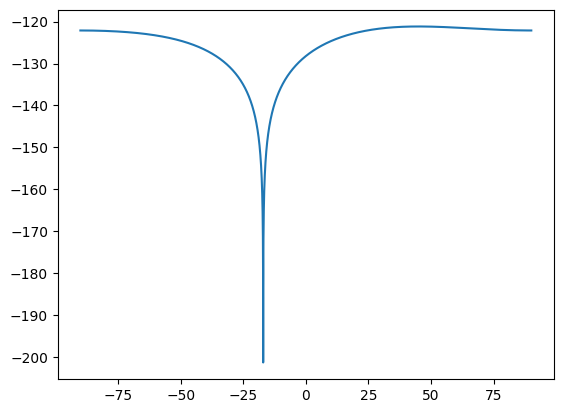

In [ ]:
barlett_angle = doa_bartlett(R)

anglebins = np.linspace(-90, 90, 100001)

plt.plot(anglebins, barlett_angle)

anglebins[np.argmax(barlett_angle)]

# MUSIC angle

In [ ]:
def doa_music(R, n_sig, d = 0.5, scan_angles = range(-90, 91)):
    """ MUSIC algorithm implementation """
    n_array = np.shape(R)[0]
    array = np.linspace(0, (n_array - 1) * d, n_array)
    scan_angles = np.array(scan_angles)

    # 'eigh' guarantees the eigen values are sorted
    _, e_vecs = np.linalg.eigh(R)
    noise_subspace = e_vecs[:, :-n_sig]

    array_grid, angle_grid = np.meshgrid(array, np.radians(scan_angles), indexing = "ij")
    steering_vec = np.exp(-1.j * 2 * np.pi * array_grid * np.sin(angle_grid)) 
    
    # 2-norm (frobenius)
    ps = 1 / np.square(np.linalg.norm(steering_vec.conj().T @ noise_subspace, axis = 1))

    return 10 * np.log10(ps)

np.float64(45.0018)

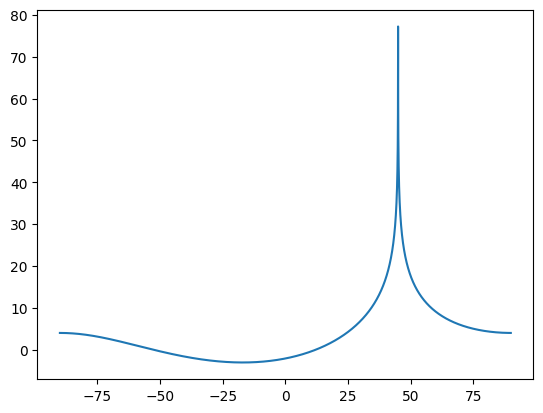

In [ ]:
barlett_angle = doa_music(R, 1, scan_angles = np.linspace(-90, 90, 100001))

anglebins = np.linspace(-90, 90, 100001)

plt.plot(anglebins, barlett_angle)

anglebins[np.argmax(barlett_angle)]